In [2]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


# "Will it snow tomorrow?" - The time traveler asked
The following dataset contains climate information form over 9000 stations accross the world. The overall goal of these subtasks will be to predict whether it will snow tomorrow 13 years ago. So if today is 2022.02.15 then the weather we want to forecast is for the date 2009.02.16. You are suppsed to solve the tasks using Big Query, which can be used in the Jupyter Notebook like it is shown in the following cell. For further information and how to used BigQuery in Jupyter Notebook refer to the Google Docs. 

The goal of this test is, to test your coding knowledge in Python, BigQuery and Pandas as well as your understanding of Data Science. If you get stuck at the first part, you can use the replacement data provided in the second part

In [3]:
# %%bigquery 
# SELECT
# *,
# FROM `bigquery-public-data.samples.gsod`
# LIMIT 20 


## Part 1

In [40]:
# import dependencies

import pandas as pd
from utils import data_characterization, drop_highly_correlated_features, extract_date_features, compute_lag_features
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

### 1. Task
Change the date format to 'YYYY-MM-DD' and select the data from 2005 till 2009 for station numbers including and between 725300 and 726300 , and save it as a pandas dataframe. Note the maximum year available is 2010. 

In [5]:
# client = bigquery.Client()
# QUERY = """
#     SELECT 
#         CAST (
#             CONCAT(CAST(year AS STRING), '-', 
#             CAST(month AS STRING) , '-' ,
#             CAST(day AS STRING)
#         ) AS DATE) AS date, * EXCEPT(year,month,day)
#     FROM bigquery-public-data.samples.gsod 
#     WHERE year BETWEEN 2005 AND 2010 AND station_number BETWEEN 725300 AND 726300
#     ORDER BY date
# """
# climate_data = client.query(QUERY).to_dataframe()
# climate_data.head(10)

In [6]:
climate_data = pd.read_csv("./coding_challenge.csv")
climate_data["date"] = pd.to_datetime(climate_data["date"], format="%Y-%m-%d")
climate_data = climate_data[climate_data.date.dt.year.isin(range(2005,2010))&climate_data.station_number.isin(range(725300, 726301))]

### 2. Task 
From here want to work with the data from all stations 725300 to 725330 that have information from 2005 till 2009. 

In [7]:
assert climate_data.date.dt.year.min()>=2005 & climate_data.date.dt.year.max()<=2009
assert climate_data.station_number.min()>=725300 & climate_data.station_number.max()<=726300

Do a first analysis of the remaining dataset, clean or drop data depending on how you see appropriate. 

In [8]:
climate_data.sort_values(by="date", inplace=True)
climate_data.head(10)

,date,station_number,mean_temp,mean_dew_point,mean_sealevel_pressure,mean_visibility,mean_wind_speed,max_temperature,total_precipitation,snow_depth,fog,snow,hail,thunder
0,2006-01-24,725300,33.200001,26.799999,1008.500000,7.0,15.200000,23.000000,0.00,1.2,False,False,False,False
3081,2006-01-24,725315,34.400002,28.000000,1013.700012,7.2,17.900000,25.000000,0.00,0.0,False,False,False,False
4623,2006-01-24,725314,39.400002,24.799999,1018.099976,8.4,9.400000,24.100000,0.00,0.0,False,False,False,False
6156,2006-01-24,725326,33.099998,27.000000,22.528572,7.6,15.600000,19.400000,0.01,0.0,False,False,False,False
7659,2006-01-24,725327,32.799999,28.100000,1010.299988,6.7,16.700001,26.600000,0.00,0.0,False,False,False,False
10706,2006-01-24,725305,32.700001,28.200001,1008.700012,6.3,17.700001,21.900000,0.00,0.0,False,False,False,False
12248,2006-01-24,725320,35.299999,27.100000,1013.900024,7.6,13.900000,25.000000,0.00,0.0,False,False,False,False
13790,2006-01-24,725316,37.000000,27.100000,1014.799988,8.7,16.000000,28.000000,0.00,0.0,False,False,False,False
9165,2006-01-24,725317,35.700001,27.799999,1014.700012,7.2,13.500000,28.000000,0.00,0.0,False,False,False,False
1540,2006-01-24,725330,31.600000,26.200001,1011.700012,7.9,14.000000,24.799999,0.01,1.2,False,False,False,False


In [9]:
# inspecting data

data_characterization(data=climate_data)

,Columns_name,Type,Nb_unique_values,Nb_Nan_values,%_Nan_values,Unique_values(value:count),mean,std,min,25%,50%,75%,max
0,date,datetime64[ns],1436,0,0.0,2006-07-06 00:00:00:10 2007-09-12 00:00:00:10 ...,-,-,-,-,-,-,-
1,station_number,int64,10,0,0.0,725315:1436 725320:1436 725305:1436 725316:143...,725316.953545,8.976016,725300.0,725314.0,725316.0,725326.0,725330.0
2,mean_temp,float64,889,0,0.0,70.30000305175781:52 70.80000305175781:51 71.1...,52.050911,19.281878,-16.200001,36.599998,54.400002,68.800003,91.400002
3,mean_dew_point,float64,865,0,0.0,57.09999847412109:53 55.200000762939446:49 58....,41.621641,18.52471,-23.5,27.299999,43.0,57.099998,79.099998
4,mean_sealevel_pressure,float64,1827,0,0.0,1017.5:109 1015.0999755859376:103 1017.2999877...,918.419074,294.431719,-10.042857,1011.0,1015.950012,1020.400024,1042.5
5,mean_visibility,float64,100,0,0.0,10.0:4927 9.899999618530272:678 9.800000190734...,8.762536,1.688685,0.6,8.1,9.6,10.0,10.9
6,mean_wind_speed,float64,235,0,0.0,5.900000095367432:197 6.5:192 4.80000019073486...,7.497662,3.635842,0.0,4.8,6.9,9.6,24.0
7,max_temperature,float64,160,0,0.0,59.0:324 60.799999237060554:295 50.0:268 28.39...,42.704935,18.676581,-34.599998,28.4,44.599998,57.900002,87.800003
8,total_precipitation,float64,308,0,0.0,0.0:9037 0.0099999997764825:770 0.019999999552...,0.100083,0.280284,0.0,0.0,0.0,0.05,5.5
9,snow_depth,float64,241,0,0.0,0.0:12944 1.2000000476837158:577 2.0:90 3.0999...,0.20421,0.778992,0.0,0.0,0.0,0.0,13.0


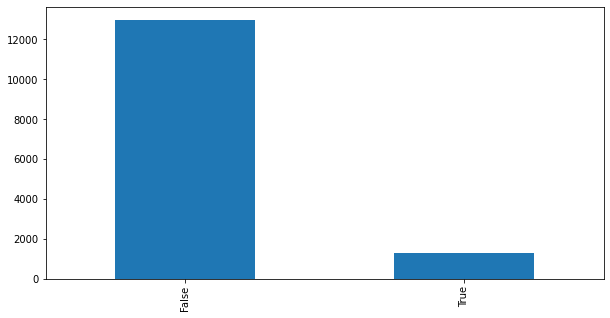

In [10]:
# Explore the target variable
climate_data.snow.value_counts().plot(kind='bar', figsize=(10,5));

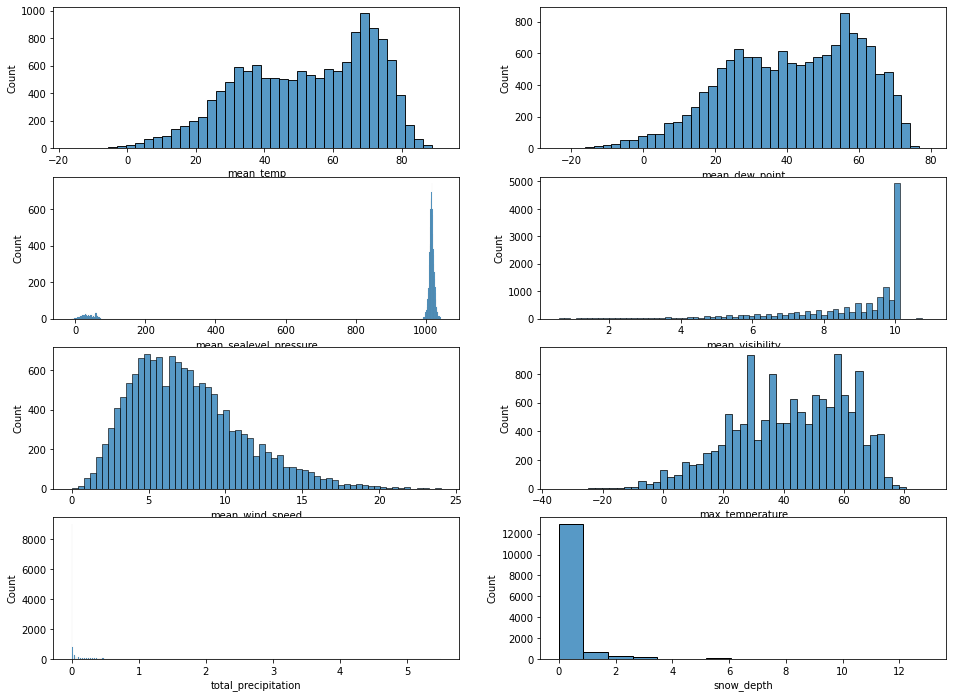

In [11]:
# Distributions numeric values
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
cols = ['mean_temp', 'mean_dew_point', 
        'mean_sealevel_pressure', 'mean_visibility', 
        'mean_wind_speed', 'max_temperature', 
        'total_precipitation', 'snow_depth']
for i, c in enumerate(cols):
    ax = axes.ravel()[i]
    sns.histplot(climate_data[c], ax=ax)

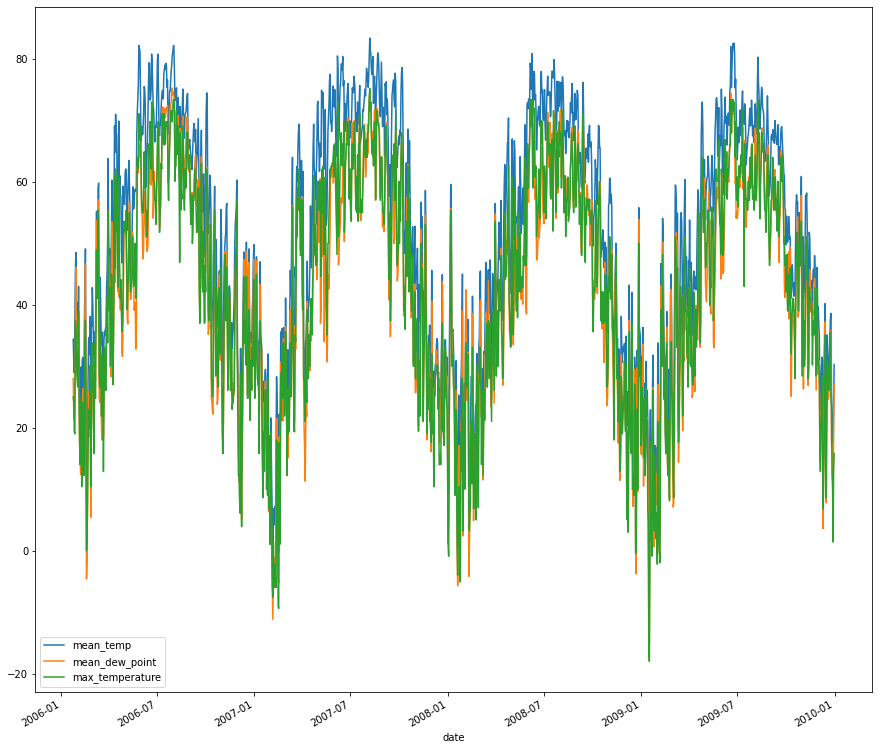

In [12]:
# Let's select a random station and check the daily `mean_temp` records
fig, ax = plt.subplots(1, 1, figsize=(15, 14))

station_nb = 725315
df = climate_data[climate_data.station_number==station_nb]
df.plot(x='date', y="mean_temp", ax=ax)
df.plot(x='date', y="mean_dew_point", ax=ax)
df.plot(x='date', y="max_temperature", ax=ax)

plt.legend();


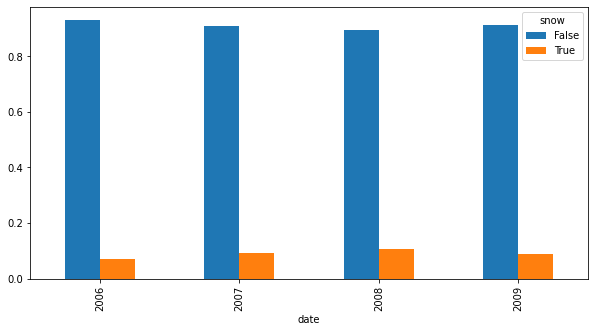

In [13]:
# Distribution snowy days per year
climate_data.groupby(climate_data.date.dt.year).snow.value_counts(normalize=True).unstack().plot(kind="bar", figsize=(10,5))
plt.show();

<AxesSubplot: xlabel='date'>

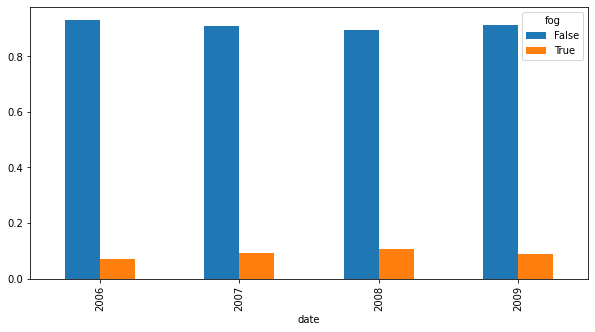

In [14]:
climate_data.groupby(climate_data.date.dt.year).fog.value_counts(normalize=True).unstack().plot(kind="bar", figsize=(10,5))

<AxesSubplot: xlabel='date'>

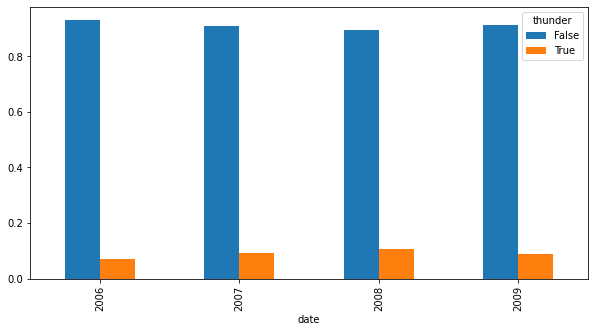

In [15]:
climate_data.groupby(climate_data.date.dt.year).thunder.value_counts(normalize=True).unstack().plot(kind="bar", figsize=(10,5))

<AxesSubplot: >

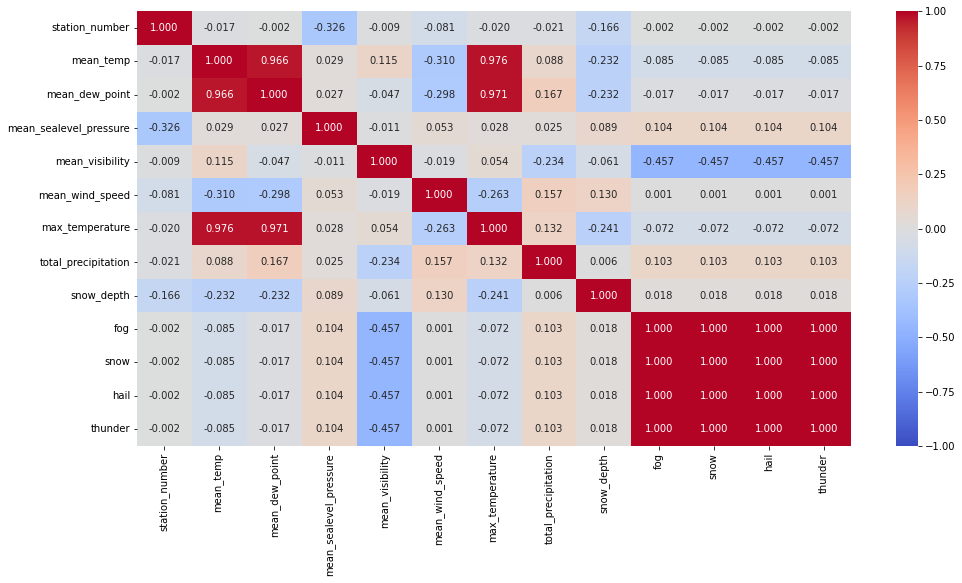

In [16]:
# Correlation Matrix
corr_matrix = climate_data.corr()
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(corr_matrix, ax=ax, annot=True, fmt=".3f", cmap='coolwarm', vmin=-1., vmax=1.)

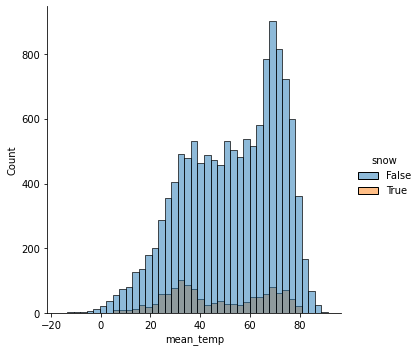

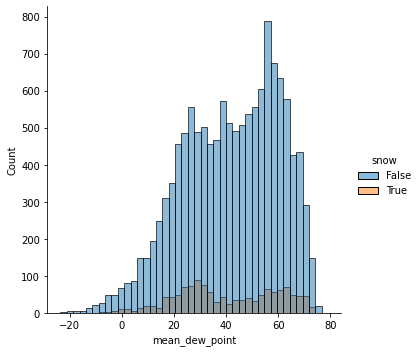

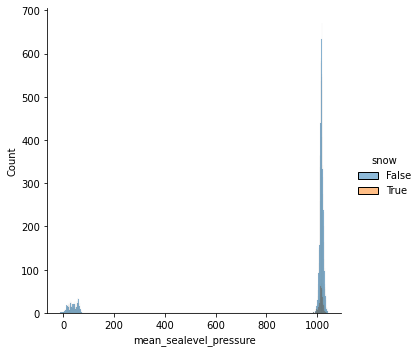

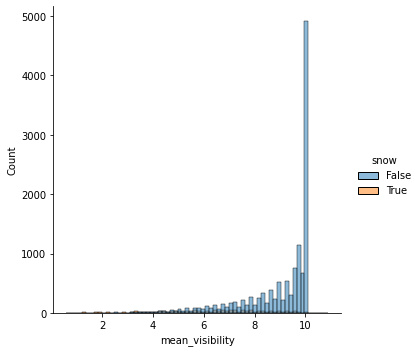

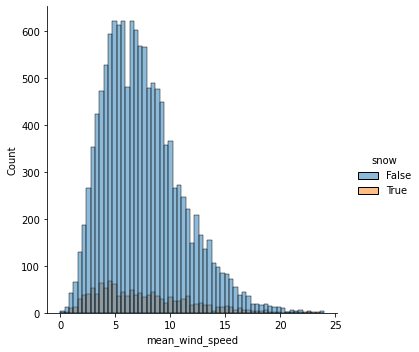

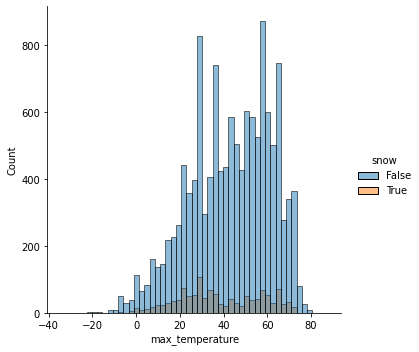

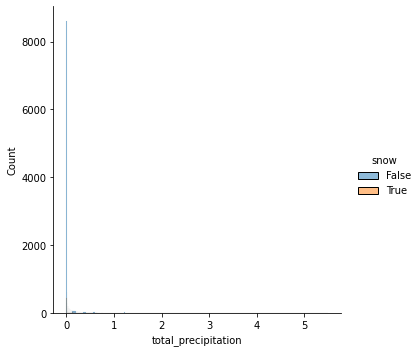

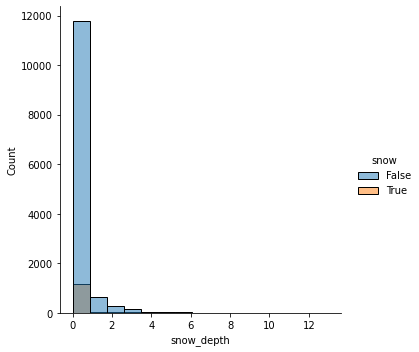

In [17]:
# Distribution plot of numeric variable  with target
target = "snow"
for i, c in enumerate(cols):
    ax = axes.ravel()[i]
    sns.displot(hue=target, x=c, data=climate_data);

- Data has no Null values
- The unit used for the `mean_temp` column is Fahrenheit. 
- Fog, hail and thunder are highly corrolated to the target "snow" 
- mean_temperature, mean_dew_point, mean_visibility and max_temperature are right skewed.
- Over the years, the number of snowy days is almost the same (~8%) 
- Total_precipitation and snow_depth is positivily skewed with a median of 0

In [18]:
climate_data.head()

,date,station_number,mean_temp,mean_dew_point,mean_sealevel_pressure,mean_visibility,mean_wind_speed,max_temperature,total_precipitation,snow_depth,fog,snow,hail,thunder
0,2006-01-24,725300,33.200001,26.799999,1008.500000,7.0,15.200000,23.0,0.00,1.2,False,False,False,False
3081,2006-01-24,725315,34.400002,28.000000,1013.700012,7.2,17.900000,25.0,0.00,0.0,False,False,False,False
4623,2006-01-24,725314,39.400002,24.799999,1018.099976,8.4,9.400000,24.1,0.00,0.0,False,False,False,False
6156,2006-01-24,725326,33.099998,27.000000,22.528572,7.6,15.600000,19.4,0.01,0.0,False,False,False,False
7659,2006-01-24,725327,32.799999,28.100000,1010.299988,6.7,16.700001,26.6,0.00,0.0,False,False,False,False


### 3. Task
Now it is time to split the data, into a training, evaluation and test set. As a reminder, the date we are trying to predict snow fall for is the following, and hence should constitute your test set.

In [19]:
import datetime as dt

str(dt.datetime.today()- dt.timedelta(days=13*365)).split(' ')[0]


'2009-09-28'

In [60]:
from datetime import date, timedelta
from typing import List
import pandas as pd
import numpy as np


def process_data(df: pd.DataFrame) -> pd.DataFrame:
    
    # remove highly correlated features
    
    df = drop_highly_correlated_features(df, except_cols=["snow"])
    df = compute_lag_features(df, "mean_temp", lags=[1])
    df = compute_lag_features(df, "snow", lags=[1])


    #extract target variable as we will predict if for a specific date, it will snow the day after
    df["target"] = compute_lag_features(df, "snow", lags=[-1]).loc[:, "Lag_snow-1"]


    df = extract_date_features(df, date_col="date")
    df.drop(columns=["date", "total_precipitation", "mean_sealevel_pressure", "fog"], inplace=True)
    # drop data where we have nan values for the target
    df.dropna(axis=0, subset=["target"], inplace=True)    

    
    df.replace({True:1, False:0}, inplace=True)
    return df 
climate_data_processed = process_data(climate_data)
climate_data_processed.head()


/home/sirine/Documents/datascience/data_science_challenge/utils.py:73: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["week"] = df[date_col].dt.week


,station_number,mean_temp,mean_visibility,mean_wind_speed,snow_depth,snow,Lag_mean_temp1,Lag_snow1,target,year,month,week,day,dayofweek
0,725300,33.200001,7.0,15.200000,1.2,0,NaN,NaN,0,2006,1,4,24,1
1,725315,34.400002,7.2,17.900000,0.0,0,NaN,NaN,0,2006,1,4,24,1
2,725314,39.400002,8.4,9.400000,0.0,0,NaN,NaN,0,2006,1,4,24,1
3,725326,33.099998,7.6,15.600000,0.0,0,NaN,NaN,0,2006,1,4,24,1
4,725327,32.799999,6.7,16.700001,0.0,0,NaN,NaN,0,2006,1,4,24,1


In [61]:
data_characterization(climate_data_processed)

,Columns_name,Type,Nb_unique_values,Nb_Nan_values,%_Nan_values,Unique_values(value:count),mean,std,min,25%,50%,75%,max
0,station_number,int64,10,0,0.000000,725315:1433 725320:1433 725305:1433 725316:143...,725316.936721,8.973996,725300.000000,725314.000000,725316.000000,725326.000000,725330.000000
1,mean_temp,float64,889,0,0.000000,70.30000305175781:52 71.19999694824219:51 69.6...,52.064349,19.244199,-16.200001,36.599998,54.299999,68.800003,91.400002
2,mean_visibility,float64,100,0,0.000000,10.0:4907 9.899999618530272:674 9.800000190734...,8.764265,1.686550,0.600000,8.100000,9.600000,10.000000,10.900000
3,mean_wind_speed,float64,234,0,0.000000,5.900000095367432:195 6.5:190 4.80000019073486...,7.505811,3.637463,0.000000,4.800000,7.000000,9.600000,24.000000
4,snow_depth,float64,241,0,0.000000,0.0:12885 1.2000000476837158:575 2.0:88 3.0999...,0.204201,0.779286,0.000000,0.000000,0.000000,0.000000,13.000000
5,snow,int64,2,0,0.000000,0:12931 1:1276,0.089815,0.285926,0.000000,0.000000,0.000000,0.000000,1.000000
6,Lag_mean_temp1,float64,888,65,0.457521,71.19999694824219:51 70.30000305175781:51 69.3...,52.079077,19.202442,-16.200001,36.700001,54.299999,68.800003,91.400002
7,Lag_snow1,float64,3,65,0.457521,0.0:12870 1.0:1272,0.089945,0.286113,0.000000,0.000000,0.000000,0.000000,1.000000
8,target,int64,2,0,0.000000,0:12926 1:1281,0.090167,0.286431,0.000000,0.000000,0.000000,0.000000,1.000000
9,year,int64,4,0,0.000000,2007:3628 2008:3621 2009:3598 2006:3360,2007.524882,1.108596,2006.000000,2007.000000,2008.000000,2009.000000,2009.000000


In [62]:
"""
Train & validation split
"""
X_train,X_valid,Y_train,Y_valid=(
    climate_data_processed[climate_data_processed.year<2009].drop(columns=["target"]), 
    climate_data_processed[climate_data_processed.year>=2009].drop(columns=["target"]), 
    climate_data_processed[climate_data_processed.year<2009][["target"]], 
    climate_data_processed[climate_data_processed.year>=2009][["target"]], 
)

In [55]:
X_train.shape[0]/climate_data_processed.shape[0], X_valid.shape[0]/climate_data_processed.shape[0]

(0.7467445625395932, 0.25325543746040685)

In [56]:
Y_train.value_counts(), Y_valid.value_counts()

(target
 0         9648
 1          961
 dtype: int64,
 target
 0         3278
 1          320
 dtype: int64)

In [49]:

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_valid = sc.transform(X_valid)

## Part 2
If you made it up to here all by yourself, you can use your prepared dataset to train an Algorithm of your choice to forecast whether it will snow on the following date for each station in this dataset:

In [38]:
import datetime as dt

str(dt.datetime.today()- dt.timedelta(days=13*365)).split(' ')[0]

'2009-09-28'

You are allowed to use any library you are comfortable with such as sklearn, tensorflow keras etc. 
If you did not manage to finish part one feel free to use the data provided in 'coding_challenge.csv' Note that this data does not represent a solution to Part 1. 

In [108]:
'''
Model: Using Xgboost for classification.
'''

estimate_weight = Y_train.value_counts()[0]/Y_train.value_counts()[1]

model = XGBClassifier(scale_pos_weight=estimate_weight, subsample=0.5, learning_rate=0.09)
model.fit(X_train, Y_train) 

Y_pred=model.predict(X_valid)
accuracy_score(Y_valid,Y_pred), f1_score(Y_valid, Y_pred)

(0.7765425236242357, 0.24577861163227013)

In [109]:
'''
Evaluate model using the confusion matrix
'''
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_valid, Y_pred)

array([[2663,  615],
       [ 189,  131]])

In [ ]:
'''
Hyperparameter tuning using Xgboost
'''
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.2,0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 3, 5]
        }

xgb = XGBClassifier(
        n_estimators=600, 
        objective='binary:logistic',
        silent=True, 
        nthread=4
)

random_search = RandomizedSearchCV(
        xgb, 
        param_distributions=params,
        n_iter=5, 
        scoring='accuracy', 
        n_jobs=4,
        cv=5
)
random_search.fit(X_train, Y_train)